# Sentiment Analysis of IMDB Movie Reviews

In [1]:
# Importing required Libraries
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import re
import nltk
import string
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import subprocess
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

## Data Collection and Preparation

In [2]:
df=pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# Summary of dataset
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [4]:
df.dtypes

review       object
sentiment    object
dtype: object

In [5]:
lm = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [6]:
df=df.sample(5000,random_state=42)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 33553 to 20382
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     5000 non-null   object
 1   sentiment  5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


## Data Preprocessing

In [8]:
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bjkha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bjkha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
def transform_data(review):
        review = review.lower()
        review = re.sub('^a-zA-Z0-9',' ',review)
        review = re.sub('<.*?>',' ',review)
        review = "".join([x for x in review if x not in string.punctuation])
        review = review.split()
        review =[lm.lemmatize(x) for x in review if x not in stop_words]
        review = " ".join(review)
        return review

tranformed= df.review.apply(transform_data)

In [10]:
tranformed

33553    really liked summerslam due look arena curtain...
9427     many television show appeal quite many differe...
199      film quickly get major chase scene ever increa...
12447    jane austen would definitely approve one gwyne...
39489    expectation somewhat high went see movie thoug...
                               ...                        
39885    one eastwoods best movie separated western goo...
17566    blurred childhood memory kept echo cult serie ...
16062    love zombiemovies love amateurproductions meat...
48445    chan new york get involved attempt sabotage ne...
20382    wife thought film watereddown madefortv bbc ve...
Name: review, Length: 5000, dtype: object

In [11]:
df_transformed = pd.DataFrame({"review":tranformed,"sentiment":df['sentiment']})

In [12]:
df_transformed.head()

,review,sentiment
33553,really liked summerslam due look arena curtain...,positive
9427,many television show appeal quite many differe...,positive
199,film quickly get major chase scene ever increa...,negative
12447,jane austen would definitely approve one gwyne...,positive
39489,expectation somewhat high went see movie thoug...,negative


## Exploratory Data Analysis (EDA)

positive    2519
negative    2481
Name: sentiment, dtype: int64


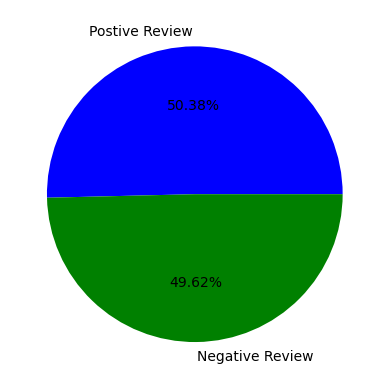

In [13]:
print(df_transformed['sentiment'].value_counts())
plt.pie(labels=['Postive Review', 'Negative Review'], 
        x = df_transformed['sentiment'].value_counts().values,
        autopct='%.2f%%',
        colors = ['Blue', 'green'])
plt.show()

### Positive Sentiments

In [14]:
tokens = str(list(df_transformed[df_transformed.sentiment=='positive'].review)).split()

In [15]:
pos_words = (" ").join(tokens)

In [16]:
wc = WordCloud(height=800,width=1200).generate(pos_words)

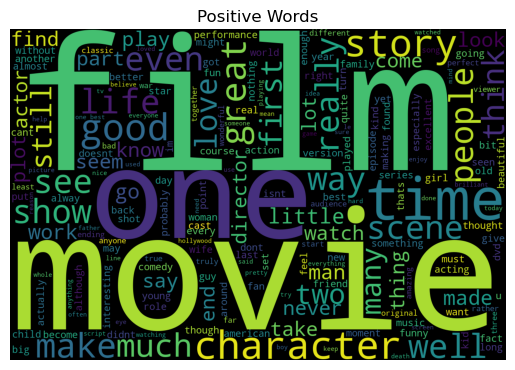

In [17]:
plt.imshow(wc)
plt.title("Positive Words")
plt.axis("off")
plt.show()

In [18]:
positive_words_frequency = Counter(tokens)

In [19]:
ps_f=positive_words_frequency.most_common(30)

In [20]:
data = pd.DataFrame(ps_f,columns=['word','freq']).sort_values('freq',ascending=False)

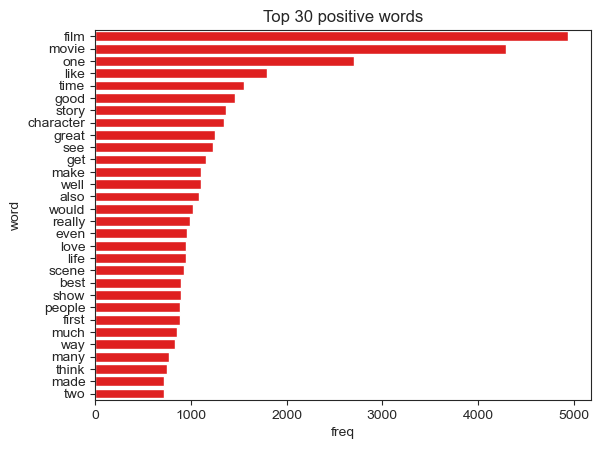

In [21]:
sns.set_style("ticks")
sns.barplot(x="freq",y='word',data=data,color='r').set(title='Top 30 positive words')

plt.show()

### Negative Sentiments

In [22]:
tokens = str(list(df_transformed[df_transformed.sentiment=='negative'].review)).split()

In [23]:
neg_words = (" ").join(tokens)

In [24]:
wc = WordCloud(height=800,width=1200).generate(neg_words)

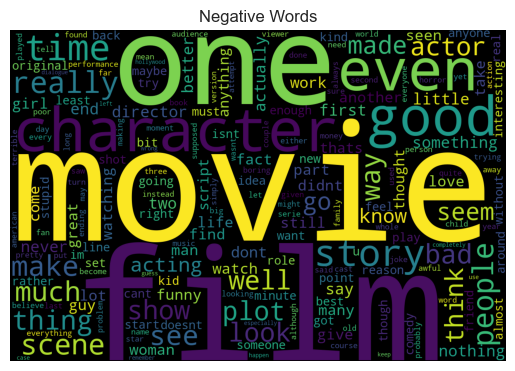

In [25]:
plt.imshow(wc)
plt.title("Negative Words")
plt.axis("off")
plt.show()

In [26]:
negative_words_frequency = Counter(tokens)

In [27]:
neg_f = negative_words_frequency.most_common(30)

In [28]:
data = pd.DataFrame(neg_f,columns=['word','freq']).sort_values('freq',ascending=False)

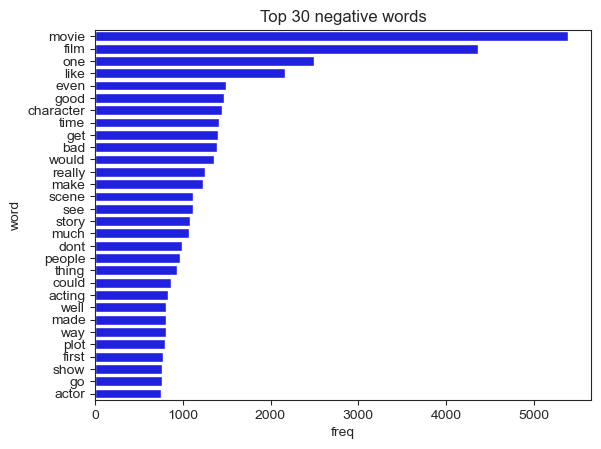

In [29]:
sns.barplot(x="freq",y='word',data=data,color='b').set(title='Top 30 negative words')

plt.show()

## Model Selection

In [30]:
df_transformed['sentiment'].replace({'positive':1,'negative':0},inplace=True)

In [31]:
X = CountVectorizer().fit_transform(df_transformed['review']).toarray()

In [32]:
print(X.shape)
y=df_transformed.iloc[:,-1].values
print(y.shape)

(5000, 43720)
(5000,)


In [33]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state = 42)

In [36]:
models={'lr':LogisticRegression(),
       'rf':RandomForestClassifier(),
       'gs':GaussianNB(),
       'knn':KNeighborsClassifier(),
       'xgb':XGBClassifier()
       }
def fit_predict(models,X_train,y_trian,X_test,y_test):
    y_pred=[]
    models_name=[]
    for model_name,model_obj in models.items():
        model_obj.fit(X_train,y_trian)
        print(f'{model_name} done....')
        y_pred.append(model_obj.predict(X_test))
        models_name.append(model_name)
    return y_pred , models_name

def get_score(y_pred,y_test):
    score=[accuracy_score(y_test,y) for y in y_pred]
    return score    

In [37]:
y_pred , models_name = fit_predict(models,X_train,y_train,X_test,y_test)

C:\Users\bjkha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


lr done....
rf done....
gs done....
knn done....


C:\Users\bjkha\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


xgb done....


In [38]:
score = get_score(y_pred,y_test)

In [39]:
md_scores = pd.DataFrame({'models':models_name,'score':score}).sort_values("score",ascending=False)

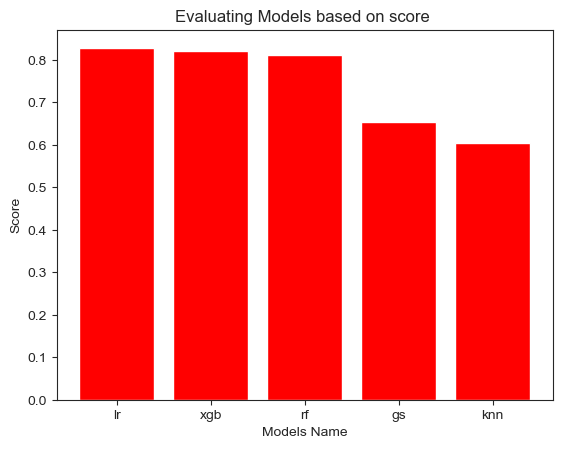

In [40]:
plt.bar('models','score',color='red',data=md_scores)
plt.title('Evaluating Models based on score ')
plt.xlabel('Models Name')
plt.ylabel('Score')
plt.show()

## Randomized Search

In [41]:
lr = LogisticRegression(penalty='l2',solver='newton-cg',random_state=42)

In [43]:
params = {'C':[12,13,14],'max_iter':[400,800]}
rm = RandomizedSearchCV(lr,params,verbose=3,cv=5)
rm.fit(X_train,y_train)

C:\Users\bjkha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................C=12, max_iter=400;, score=0.853 total time=  49.1s
[CV 2/5] END ................C=12, max_iter=400;, score=0.853 total time=  51.8s
[CV 3/5] END ................C=12, max_iter=400;, score=0.848 total time=  45.7s
[CV 4/5] END ................C=12, max_iter=400;, score=0.840 total time=  45.8s
[CV 5/5] END ................C=12, max_iter=400;, score=0.839 total time=  46.0s
[CV 1/5] END ................C=12, max_iter=800;, score=0.853 total time=  51.9s
[CV 2/5] END ................C=12, max_iter=800;, score=0.853 total time=  51.4s
[CV 3/5] END ................C=12, max_iter=800;, score=0.848 total time=  46.1s
[CV 4/5] END ................C=12, max_iter=800;, score=0.840 total time=  50.5s
[CV 5/5] END ................C=12, max_iter=800;, score=0.839 total time=  46.1s
[CV 1/5] END ................C=13, max_iter=400;, score=0.853 total time=  52.8s
[CV 2/5] END ................C=13, max_iter=400;,

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(random_state=42,
                                                solver='newton-cg'),
                   param_distributions={'C': [12, 13, 14],
                                        'max_iter': [400, 800]},
                   verbose=3)

In [44]:
rm.best_score_

0.8462500000000001

In [45]:
rm.best_estimator_

LogisticRegression(C=12, max_iter=400, random_state=42, solver='newton-cg')

In [46]:
lr = LogisticRegression(C=12,penalty='l2',solver='newton-cg',max_iter=400,random_state=42)
lr.fit(X_train,y_train)

LogisticRegression(C=12, max_iter=400, random_state=42, solver='newton-cg')

In [47]:
y_pred = lr.predict(X_test)

In [48]:
accuracy_score(y_test,y_pred)

0.826

In [49]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[410,  93],
       [ 81, 416]], dtype=int64)

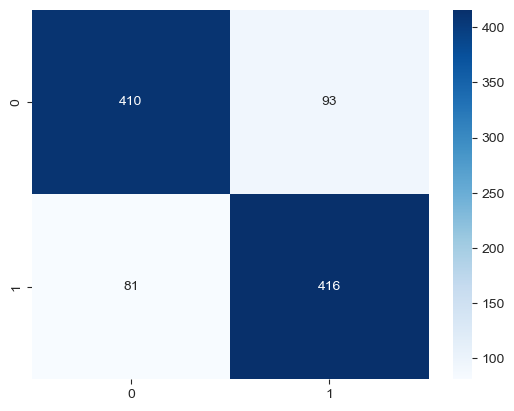

In [50]:
sns.heatmap(cm,annot=True,cmap='Blues', fmt='g')
plt.show()

In [51]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.82       503
           1       0.82      0.84      0.83       497

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000

